In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad
import heapq

In [2]:
img = cv2.imread("-47,90.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]
center_x, center_y = W // 2, H // 2
center = np.array([center_x, center_y])

In [3]:
points = [
    {"name": "red",    "pixel": (146, 451), "lat": -58.668, "lon": 76.997,  "color": (255, 0, 0)},
    {"name": "green",  "pixel": (89, 200),  "lat": -42.734, "lon": 75.612,  "color": (0, 255, 0)},
    {"name": "blue",   "pixel": (414, 73),  "lat": -34.682, "lon": 102.153, "color": (0, 0, 255)},
]

In [4]:
distances1 = []

for pt in points:
    dist = np.linalg.norm(np.array(pt["pixel"]) - center)
    distances1.append(dist)

min_index = np.argmin(distances1)
main_point = points[min_index]

for i, (pt, dist) in enumerate(zip(points, distances1)):
    print(f"Point {i+1} - Coordinate: {pt}, Distance to the Center: {dist:.2f}")

x_main, y_main = main_point["pixel"]

print(f"\nMain Point: {main_point}")

Point 1 - Coordinate: {'name': 'red', 'pixel': (146, 451), 'lat': -58.668, 'lon': 76.997, 'color': (255, 0, 0)}, Distance to the Center: 223.89
Point 2 - Coordinate: {'name': 'green', 'pixel': (89, 200), 'lat': -42.734, 'lon': 75.612, 'color': (0, 255, 0)}, Distance to the Center: 176.14
Point 3 - Coordinate: {'name': 'blue', 'pixel': (414, 73), 'lat': -34.682, 'lon': 102.153, 'color': (0, 0, 255)}, Distance to the Center: 241.77

Main Point: {'name': 'green', 'pixel': (89, 200), 'lat': -42.734, 'lon': 75.612, 'color': (0, 255, 0)}


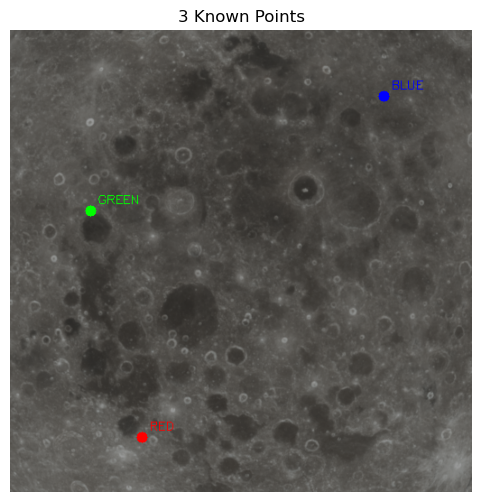

In [5]:
img_annotated1 = img.copy()

for pt in points:
    x, y = pt["pixel"]
    cv2.circle(img_annotated1, (x, y), radius=6, color=pt["color"], thickness=-1)
    label = f"{pt['name'].upper()}\n({pt['lat']:.3f}, {pt['lon']:.3f})"
    cv2.putText(img_annotated1, pt["name"].upper(), (x + 8, y - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, pt["color"], 1)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated1)
plt.title("3 Known Points")
plt.axis('off')
plt.show()

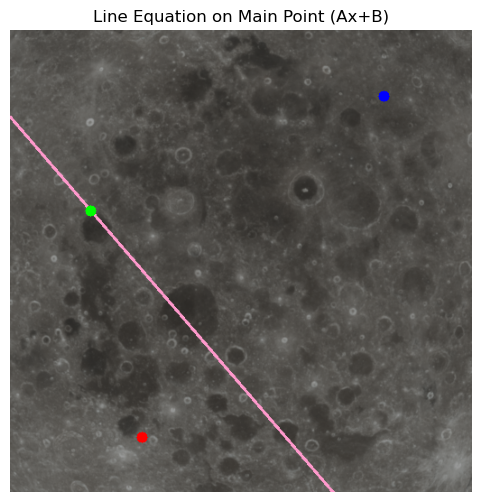

In [6]:
img_annotated2 = img.copy()

A = -1.163
B = (H - y_main) - A * x_main

x1, x2 = 0, W - 1
y1 = int(H - (A * x1 + B))
y2 = int(H - (A * x2 + B))

cv2.line(img_annotated2, (x1, y1), (x2, y2), color=(255, 153, 204), thickness=2)

for pt in points:
    x, y = pt["pixel"]
    cv2.circle(img_annotated2, (x, y), radius=6, color=pt["color"], thickness=-1)
    label = f"{pt['name'].upper()}\n({pt['lat']:.3f}, {pt['lon']:.3f})"
    cv2.putText(img_annotated1, pt["name"].upper(), (x + 8, y - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, pt["color"], 1)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated2)
plt.title("Line Equation on Main Point (Ax+B)")
plt.axis('off')
plt.show()

In [7]:
moon_radius_km = 1737.0

main_lat = main_point["lat"]
main_name = main_point["name"]
main_lon = main_point["lon"]

remaining_points = [pt for pt in points if pt != main_point]

print("Real Distances Between Latitudes of 3 Points:\n")
for pt in remaining_points:
    delta_lat = math.radians(abs(pt["lat"] - main_lat))
    distance = delta_lat * moon_radius_km
    pt["lat_dist_km"] = distance
    print(f"Distance from {main_name.upper()} (main point) to {pt['name'].upper()}: {distance:.2f} km")

print("\n")

pt1, pt2 = remaining_points  
d1_lat = pt1["lat_dist_km"]
d2_lat = pt2["lat_dist_km"]

n_main = main_point["name"].upper()
n1 = pt1["name"].upper()
n2 = pt2["name"].upper()

if d2_lat != 0:
    real_lat_ratio = d1_lat / d2_lat

    print(f"The ratio of the real latitude distance between {n_main} and {n1}, "
          f"to the real latitude distance between {n_main} and {n2} is:")
    print(f"    ratio = latitude distance({n_main} ↔ {n1}) / latitude distance({n_main} ↔ {n2})")
    print(f"          = {d1_lat:.2f} / {d2_lat:.2f} = {real_lat_ratio:.4f}")
else:
    print(f"\nCannot compute ratio: {n_main} and {n2} are on the same latitude (division by zero).")

Real Distances Between Latitudes of 3 Points:

Distance from GREEN (main point) to RED: 483.06 km
Distance from GREEN (main point) to BLUE: 244.11 km


The ratio of the real latitude distance between GREEN and RED, to the real latitude distance between GREEN and BLUE is:
    ratio = latitude distance(GREEN ↔ RED) / latitude distance(GREEN ↔ BLUE)
          = 483.06 / 244.11 = 1.9789


In [8]:
A_vals = np.concatenate([
    np.arange(-20, -5, 1.0),
    np.arange(-5,  5.0001, 0.01),
    np.arange( 6,  21, 1.0)
])

p0 = np.array(main_point["pixel"]) 
p1 = np.array(pt1["pixel"])
p2 = np.array(pt2["pixel"])

def point_line_distance(pt, p0, v):
    return abs(np.cross(v, pt - p0)) / np.linalg.norm(v)
    
distances2 = []

for A in A_vals:
    B = (H - p0[1]) - A * p0[0]
    v = np.array([1, -A])
    d1 = point_line_distance(p1, p0, v)
    d2 = point_line_distance(p2, p0, v) 
    ratio = d1 / d2 if d2 != 0 else np.nan
    distances2.append([d1, d2, ratio])

distances2 = np.array(distances2)
d1_vals = distances2[:, 0]
d2_vals = distances2[:, 1]
ratio_vals = distances2[:, 2]

diffs = np.abs(ratio_vals - real_lat_ratio)

global_indices = np.argsort(diffs)[:2]
A_best_vals = A_vals[global_indices]
A_best_vals[np.isclose(A_best_vals, 0, atol=1e-8)] = 0.01
ratio_best_vals = ratio_vals[global_indices]

print("Real Ratio ≈ {:.4f}".format(real_lat_ratio))
print("\nClosest 2 A values:")
for a, r in zip(A_best_vals, ratio_best_vals):
    print(f"   → A = {a:.4f}, Ratio = {r:.4f}")

Real Ratio ≈ 1.9789

Closest 2 A values:
   → A = 0.0100, Ratio = 1.9764
   → A = 0.8600, Ratio = 1.9673


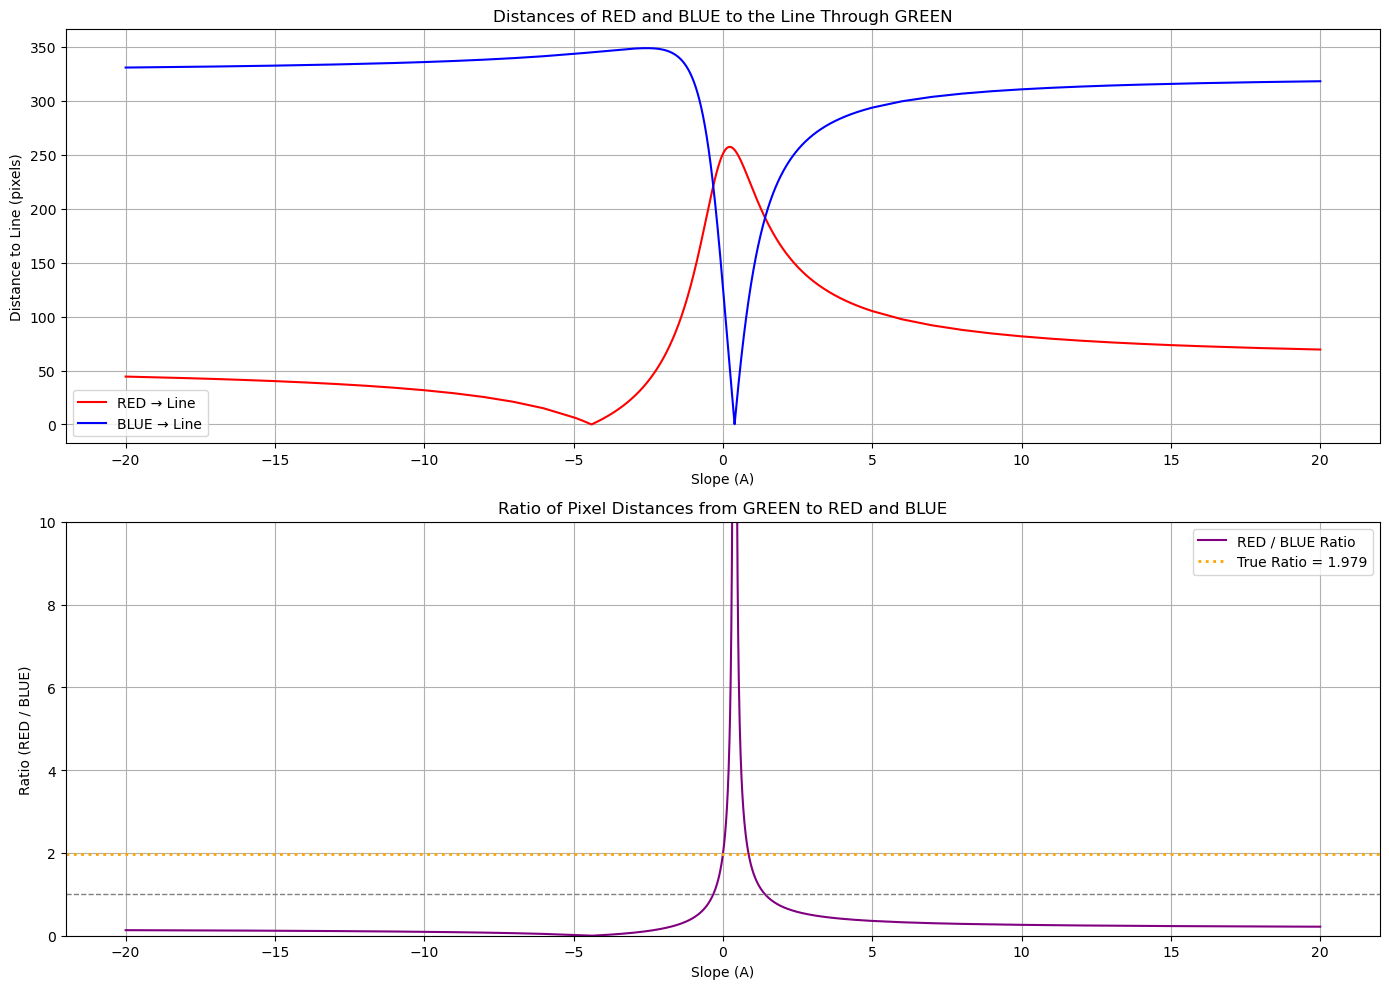

In [9]:
n_main = main_point["name"].upper()
n1 = pt1["name"].upper()
n2 = pt2["name"].upper()

plt.figure(figsize=(14, 10))

plt.subplot(2, 1, 1)
plt.plot(A_vals, d1_vals, label=f"{n1} → Line", color='red')
plt.plot(A_vals, d2_vals, label=f"{n2} → Line", color='blue')
plt.xlabel("Slope (A)")
plt.ylabel("Distance to Line (pixels)")
plt.title(f"Distances of {n1} and {n2} to the Line Through {n_main}")
plt.legend(); plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(A_vals, ratio_vals, label=f"{n1} / {n2} Ratio", color='purple')
plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.axhline(real_lat_ratio, color='orange', linestyle=':', linewidth=2, label=f"True Ratio = {real_lat_ratio:.3f}")
plt.axhline(-real_lat_ratio, color='orange', linestyle=':', linewidth=2)
plt.ylim(0, 10)
plt.xlabel("Slope (A)")
plt.ylabel(f"Ratio ({n1} / {n2})")
plt.title(f"Ratio of Pixel Distances from {n_main} to {n1} and {n2}")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

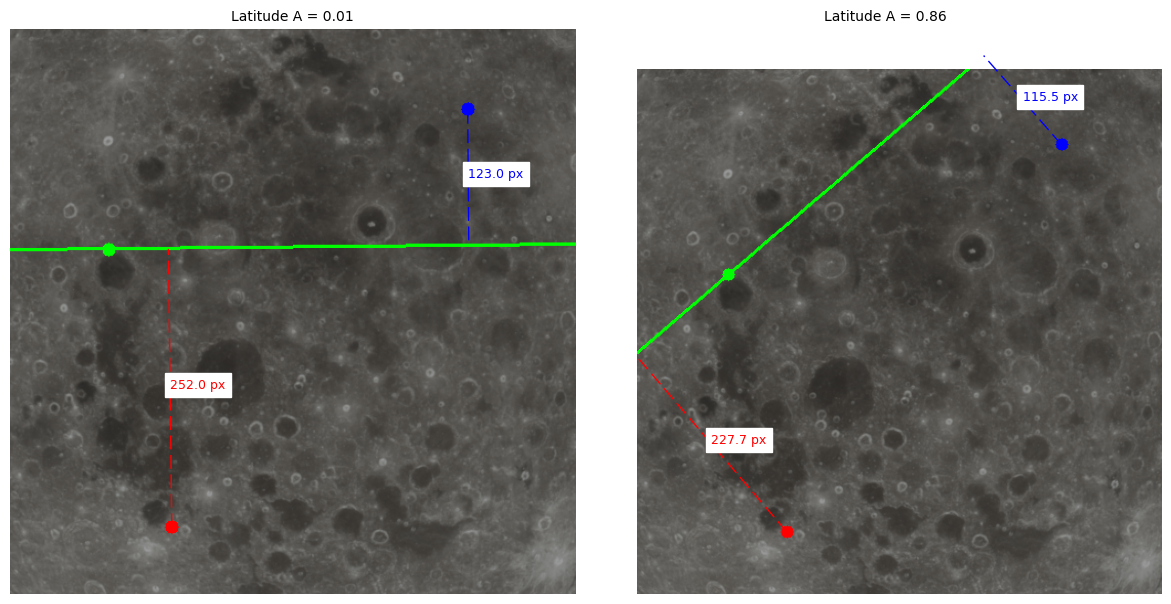

In [10]:
def project_point_to_line(pt, p0, v):
    v = v / np.linalg.norm(v)
    proj = p0 + np.dot(pt - p0, v) * v
    return proj.astype(int)

def normalize_color(color):
    return tuple(c / 255 for c in color)
    
def create_latitude_visual(ax, img, A_val, main_point, pt1, pt2, W, H):
    img_vis = img.copy()
    p0 = np.array(main_point["pixel"])
    p1 = np.array(pt1["pixel"])
    p2 = np.array(pt2["pixel"])

    B = (H - p0[1]) - A_val * p0[0]
    v = np.array([1, -A_val])

    x1, x2 = 0, W - 1
    y1 = int(H - (A_val * x1 + B))
    y2 = int(H - (A_val * x2 + B))
    cv2.line(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    cv2.circle(img_vis, tuple(p0), 6, (0, 255, 0), -1)
    cv2.circle(img_vis, tuple(p1), 6, (255, 0, 0), -1)
    cv2.circle(img_vis, tuple(p2), 6, (0, 0, 255), -1)

    proj1 = project_point_to_line(p1, p0, v)
    proj2 = project_point_to_line(p2, p0, v)
    
    d1 = np.linalg.norm(p1 - proj1)
    d2 = np.linalg.norm(p2 - proj2)

    mid1 = (p1 + proj1) / 2
    mid2 = (p2 + proj2) / 2
    label1 = f"{d1:.1f} px"
    label2 = f"{d2:.1f} px"

    ax.imshow(img_vis)
    ax.plot([p1[0], proj1[0]], [p1[1], proj1[1]], color=normalize_color(pt1["color"]), linestyle=(0, (10, 4)), linewidth=1)
    ax.plot([p2[0], proj2[0]], [p2[1], proj2[1]], color=normalize_color(pt2["color"]), linestyle=(0, (10, 4)), linewidth=1)
    ax.text(mid1[0], mid1[1], label1, color=normalize_color(pt1["color"]), fontsize=9, backgroundcolor='white')
    ax.text(mid2[0], mid2[1], label2, color=normalize_color(pt2["color"]), fontsize=9, backgroundcolor='white')
    ax.set_title(f"Latitude A = {A_val:.2f}", fontsize=10)
    ax.axis('off')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

create_latitude_visual(axes[0], img, A_best_vals[0], main_point, pt1, pt2, W, H)
create_latitude_visual(axes[1], img, A_best_vals[1], main_point, pt1, pt2, W, H)

plt.tight_layout()
plt.show()

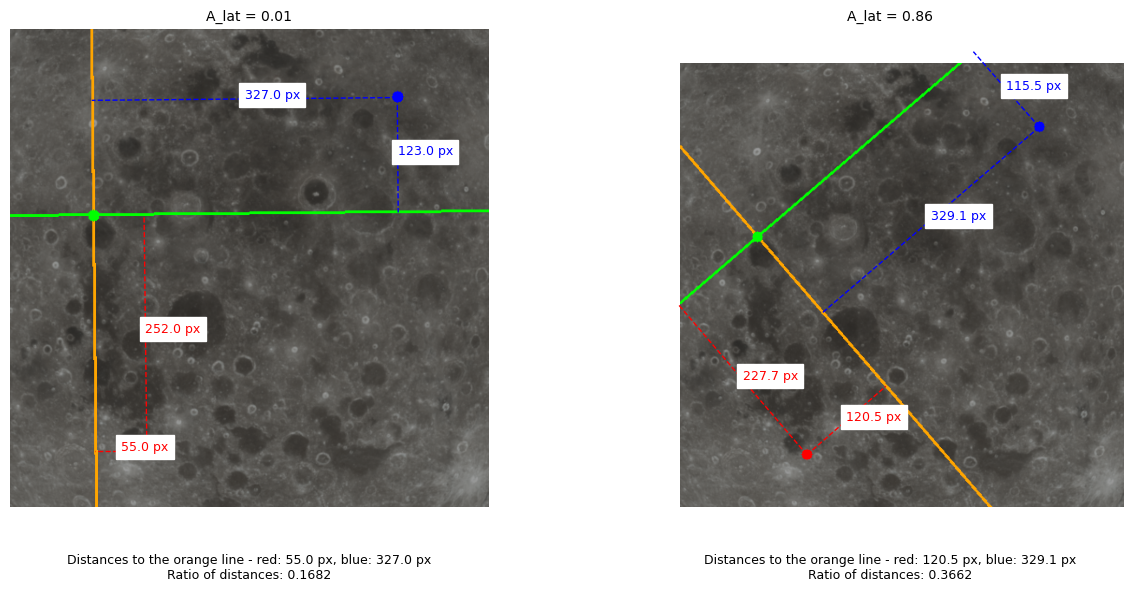

In [11]:
golden_ratios = []

def create_latitude_visual_v2(ax, img, A_lat, main_point, pt1, pt2, W, H):
    img_vis = img.copy()
    p0 = np.array(main_point["pixel"])
    p1 = np.array(pt1["pixel"])
    p2 = np.array(pt2["pixel"])

    B_lat = (H - p0[1]) - A_lat * p0[0]
    v_lat = np.array([1, -A_lat])
    x1, x2 = 0, W - 1
    y1 = int(H - (A_lat * x1 + B_lat))
    y2 = int(H - (A_lat * x2 + B_lat))
    cv2.line(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    A_lon = -1 / A_lat
    B_lon = (H - p0[1]) - A_lon * p0[0]
    v_lon = np.array([1, -A_lon])
    x1_lon, x2_lon = 0, W - 1
    y1_lon = int(H - (A_lon * x1_lon + B_lon))
    y2_lon = int(H - (A_lon * x2_lon + B_lon))
    cv2.line(img_vis, (x1_lon, y1_lon), (x2_lon, y2_lon), (255, 165, 0), 2)

    cv2.circle(img_vis, tuple(p0), 6, (0, 255, 0), -1)
    cv2.circle(img_vis, tuple(p1), 6, (255, 0, 0), -1)
    cv2.circle(img_vis, tuple(p2), 6, (0, 0, 255), -1)

    proj1_lat = project_point_to_line(p1, p0, v_lat)
    proj2_lat = project_point_to_line(p2, p0, v_lat)
    d1_lat = np.linalg.norm(p1 - proj1_lat)
    d2_lat = np.linalg.norm(p2 - proj2_lat)
    mid1_lat = (p1 + proj1_lat) / 2
    mid2_lat = (p2 + proj2_lat) / 2
    label1_lat = f"{d1_lat:.1f} px"
    label2_lat = f"{d2_lat:.1f} px"

    proj1_lon = project_point_to_line(p1, p0, v_lon)
    proj2_lon = project_point_to_line(p2, p0, v_lon)
    d1_lon = np.linalg.norm(p1 - proj1_lon)
    d2_lon = np.linalg.norm(p2 - proj2_lon)
    ratio_lon = d1_lon / d2_lon if d2_lon != 0 else float('inf')
    golden_ratios.append(ratio_lon)

    ax.imshow(img_vis)
    ax.plot([p1[0], proj1_lat[0]], [p1[1], proj1_lat[1]], color=normalize_color(pt1["color"]), linestyle='dashed', linewidth=1)
    ax.plot([p2[0], proj2_lat[0]], [p2[1], proj2_lat[1]], color=normalize_color(pt2["color"]), linestyle='dashed', linewidth=1)
    ax.text(mid1_lat[0], mid1_lat[1], label1_lat, color=normalize_color(pt1["color"]), fontsize=9, backgroundcolor='white')
    ax.text(mid2_lat[0], mid2_lat[1], label2_lat, color=normalize_color(pt2["color"]), fontsize=9, backgroundcolor='white')

    ax.plot([p1[0], proj1_lon[0]], [p1[1], proj1_lon[1]], color=normalize_color(pt1["color"]), linestyle='dashed', linewidth=1)
    ax.plot([p2[0], proj2_lon[0]], [p2[1], proj2_lon[1]], color=normalize_color(pt2["color"]), linestyle='dashed', linewidth=1)
    ax.text((p1[0] + proj1_lon[0]) / 2, (p1[1] + proj1_lon[1]) / 2, f"{d1_lon:.1f} px", color=normalize_color(pt1["color"]), fontsize=9, backgroundcolor='white')
    ax.text((p2[0] + proj2_lon[0]) / 2, (p2[1] + proj2_lon[1]) / 2, f"{d2_lon:.1f} px", color=normalize_color(pt2["color"]), fontsize=9, backgroundcolor='white')

    ax.set_title(f"A_lat = {A_lat:.2f}", fontsize=10)
    ax.axis('off')

    info_text = f"Distances to the orange line - {pt1['name']}: {d1_lon:.1f} px, {pt2['name']}: {d2_lon:.1f} px\nRatio of distances: {ratio_lon:.4f}"
    ax.text(0.5, -0.15, info_text, color='black', fontsize=9, ha='center', transform=ax.transAxes)

fig, axes = plt.subplots(1, 2, figsize=(13, 6))
create_latitude_visual_v2(axes[0], img, A_best_vals[0], main_point, pt1, pt2, W, H)
create_latitude_visual_v2(axes[1], img, A_best_vals[1], main_point, pt1, pt2, W, H)
plt.tight_layout()
plt.show()

Real Distances Between Longitudes of 3 Points:

Distance from GREEN (main point) to RED: 21.83 km
Distance from GREEN (main point) to BLUE: 661.66 km
The ratio of the real longitude distance between GREEN and RED, to the real longitude distance between GREEN and BLUE is:
    ratio = longitude distance(GREEN ↔ RED) / longitude distance(GREEN ↔ BLUE)
          = 21.83 / 661.66 = 0.0330


Best A value:
   → A = -3.6400, Ratio = 0.0332


Real Ratio: 0.16818864075266352


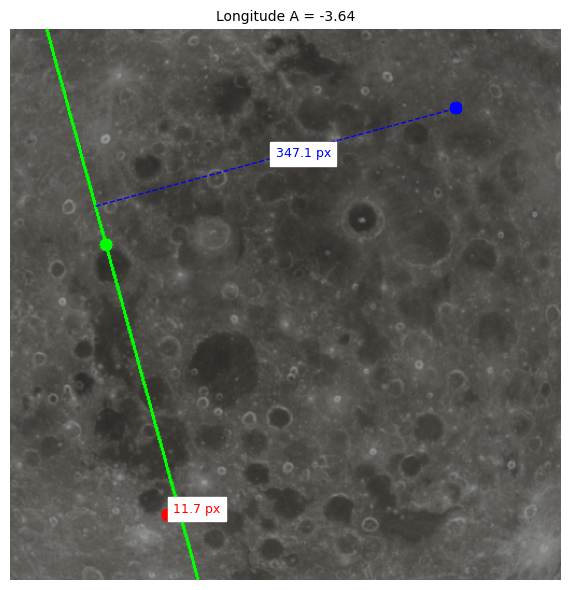

In [12]:
print("Real Distances Between Longitudes of 3 Points:\n")
for pt in remaining_points:
    lat_rad = math.radians(pt["lat"])
    delta_lon = math.radians(abs(pt["lon"] - main_point["lon"]))
    distance = delta_lon * moon_radius_km * math.cos(lat_rad)
    pt["lon_dist_km"] = distance
    print(f"Distance from {main_point['name'].upper()} (main point) to {pt['name'].upper()}: {distance:.2f} km")

d1_lon = pt1["lon_dist_km"]
d2_lon = pt2["lon_dist_km"]
real_lon_ratio = d1_lon / d2_lon

print(f"The ratio of the real longitude distance between {n_main} and {n1}, "f"to the real longitude distance between {n_main} and {n2} is:")
print(f"    ratio = longitude distance({n_main} ↔ {n1}) / longitude distance({n_main} ↔ {n2})")
print(f"          = {d1_lon:.2f} / {d2_lon:.2f} = {real_lon_ratio:.4f}")

A_vals = np.concatenate([
    np.arange(-20, -5, 1.0),
    np.arange(-5, 5.0001, 0.01),
    np.arange(6, 21, 1.0)
])

p0 = np.array(main_point["pixel"])
p1 = np.array(pt1["pixel"])
p2 = np.array(pt2["pixel"])

def point_line_distance(pt, p0, v):
    return abs(np.cross(v, pt - p0)) / np.linalg.norm(v)

distances2 = []
for A in A_vals:
    B = (H - p0[1]) - A * p0[0]
    v = np.array([1, -A])
    d1 = point_line_distance(p1, p0, v)
    d2 = point_line_distance(p2, p0, v)
    ratio = d1 / d2 if d2 != 0 else np.nan
    distances2.append([d1, d2, ratio])

distances2 = np.array(distances2)
ratio_vals = distances2[:, 2]

diffs = np.abs(ratio_vals - real_lon_ratio)
global_index = np.argsort(diffs)[0] 
A_best_val = A_vals[global_index]
ratio_best_val = ratio_vals[global_index]


print("\n\nBest A value:")
print(f"   → A = {A_best_val:.4f}, Ratio = {ratio_best_val:.4f}")

golden_ratio = min(golden_ratios, key=lambda x: abs(x - ratio))
print("\n\nReal Ratio:", golden_ratio)

def normalize_color(color):
    return tuple(c / 255 for c in color)

def create_longitude_visual(ax, img, A_val, main_point, pt1, pt2, W, H):
    img_vis = img.copy()
    
    B = (H - p0[1]) - A_val * p0[0]
    v = np.array([1, -A_val])
    x1, x2 = 0, W - 1
    y1 = int(H - (A_val * x1 + B))
    y2 = int(H - (A_val * x2 + B))
    
    cv2.line(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.circle(img_vis, tuple(p0), 6, (0, 255, 0), -1)
    cv2.circle(img_vis, tuple(p1), 6, (255, 0, 0), -1)
    cv2.circle(img_vis, tuple(p2), 6, (0, 0, 255), -1)
    
    proj1 = project_point_to_line(p1, p0, v)
    proj2 = project_point_to_line(p2, p0, v)
    
    d1 = np.linalg.norm(p1 - proj1)
    d2 = np.linalg.norm(p2 - proj2)
    
    mid1 = (p1 + proj1) / 2
    mid2 = (p2 + proj2) / 2
    
    label1 = f"{d1:.1f} px"
    label2 = f"{d2:.1f} px"
    
    ax.imshow(img_vis)
    ax.plot([p1[0], proj1[0]], [p1[1], proj1[1]], color=normalize_color(pt1["color"]), linestyle='dashed', linewidth=1)
    ax.plot([p2[0], proj2[0]], [p2[1], proj2[1]], color=normalize_color(pt2["color"]), linestyle='dashed', linewidth=1)
    ax.text(mid1[0], mid1[1], label1, color=normalize_color(pt1["color"]), fontsize=9, backgroundcolor='white')
    ax.text(mid2[0], mid2[1], label2, color=normalize_color(pt2["color"]), fontsize=9, backgroundcolor='white')
    ax.set_title(f"Longitude A = {A_val:.2f}", fontsize=10)
    ax.axis('off')

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
create_longitude_visual(ax, img, A_best_val, main_point, pt1, pt2, W, H)
plt.tight_layout()
plt.show()

In [13]:
latitude_scenarios = []

for idx, A_lat in enumerate(A_best_vals):
    
    x0, y0 = main_point["pixel"]
    B_lat = (H - y0) - A_lat * x0
    A_lon = -1 / A_lat if not np.isclose(A_lat, 0, atol=1e-8) else float('inf')
    
    if np.isfinite(A_lon):
        B_lon = (H - y0) - A_lon * x0
    else:
        B_lon = (H - y0) - (A_lon+0.01) * x0
        
    v_lon = np.array([1, -A_lon]) if np.isfinite(A_lon) else np.array([0, 1])
    p0 = np.array([x0, y0])
    p1 = np.array(pt1["pixel"])
    p2 = np.array(pt2["pixel"])

    d1 = point_line_distance(p1, p0, v_lon)
    d2 = point_line_distance(p2, p0, v_lon)
    ratio = d1 / d2 if d2 != 0 else float('inf')

    scenario_name = f"A_lat = {A_lat:.2f}"

    scenario = {
        "name": scenario_name,
        "A_lat": A_lat,
        "B_lat": B_lat,
        "A_lon": A_lon,
        "B_lon": B_lon,
        "pixel_distances": {
            pt1["name"]: round(d1, 2),
            pt2["name"]: round(d2, 2),
            "ratio": round(ratio, 5)
        }
    }

    latitude_scenarios.append(scenario)


print("Scenarios:\n")

for idx, scenario in enumerate(latitude_scenarios):
    print(f"--- Scenario {idx + 1} ---")
    print(f"Name       : {scenario['name']}")
    print(f"A_lat      : {scenario['A_lat']:.4f}")
    print(f"B_lat      : {scenario['B_lat']:.4f}")
    
    A_lon = scenario['A_lon']
    B_lon = scenario['B_lon']
    
    if np.isfinite(A_lon):
        print(f"A_lon      : {A_lon:.4f}")
        print(f"B_lon      : {B_lon:.4f}")
    else:
        print(f"A_lon      : ∞ (vertical)")
        print(f"B_lon      : undefined")

    print("\nPixel Distances:")
    for k, v in scenario["pixel_distances"].items():
        print(f"   {k.upper():<6}: {v}")
    
    print("\n")

Scenarios:

--- Scenario 1 ---
Name       : A_lat = 0.01
A_lat      : 0.0100
B_lat      : 311.1100
A_lon      : -100.0000
B_lon      : 9212.0000

Pixel Distances:
   RED   : 54.49
   BLUE  : 326.25
   RATIO : 0.16701


--- Scenario 2 ---
Name       : A_lat = 0.86
A_lat      : 0.8600
B_lat      : 235.4600
A_lon      : -1.1628
B_lon      : 415.4884

Pixel Distances:
   RED   : 120.45
   BLUE  : 329.22
   RATIO : 0.36585




In [14]:
for s in latitude_scenarios:
    print(f"{s['name']}: ratio = {s['pixel_distances']['ratio']}")

A_lat = 0.01: ratio = 0.16701
A_lat = 0.86: ratio = 0.36585


In [15]:
best_index = min(
    range(len(latitude_scenarios)),
    key=lambda i: abs(latitude_scenarios[i]["pixel_distances"]["ratio"] - golden_ratio)
)

best_latitude_scenario = {
    "name": latitude_scenarios[best_index]["name"],
    "A_lat": latitude_scenarios[best_index]["A_lat"],
    "B_lat": latitude_scenarios[best_index]["B_lat"],
    "A_lon": latitude_scenarios[best_index]["A_lon"],
    "B_lon": latitude_scenarios[best_index]["B_lon"],
    "pixel_distances": dict(latitude_scenarios[best_index]["pixel_distances"]),
}

loser_index = 1 - best_index
loser_latitude_scenario = {
    "name": latitude_scenarios[loser_index]["name"],
    "A_lat": latitude_scenarios[loser_index]["A_lat"],
    "B_lat": latitude_scenarios[loser_index]["B_lat"],
    "A_lon": latitude_scenarios[loser_index]["A_lon"],
    "B_lon": latitude_scenarios[loser_index]["B_lon"],
    "pixel_distances": dict(latitude_scenarios[loser_index]["pixel_distances"]),
}

print("Winner Scenario:")
print(best_latitude_scenario)
print("\nLoser Scenario:")
print(loser_latitude_scenario)

Winner Scenario:
{'name': 'A_lat = 0.01', 'A_lat': 0.01, 'B_lat': 311.11, 'A_lon': -100.0, 'B_lon': 9212.0, 'pixel_distances': {'red': 54.49, 'blue': 326.25, 'ratio': 0.16701}}

Loser Scenario:
{'name': 'A_lat = 0.86', 'A_lat': 0.8599999999998751, 'B_lat': 235.46000000001112, 'A_lon': -1.1627906976745874, 'B_lon': 415.48837209303827, 'pixel_distances': {'red': 120.45, 'blue': 329.22, 'ratio': 0.36585}}


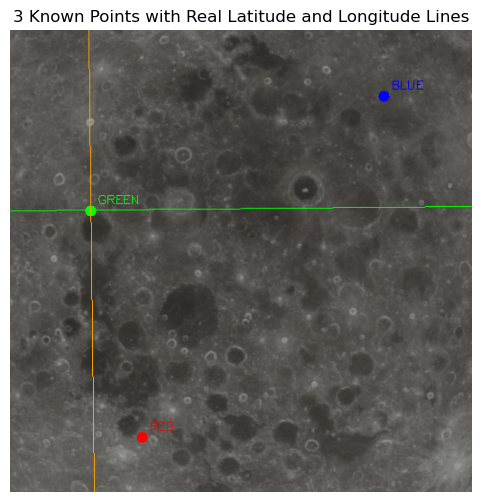

In [16]:
best_scenario = best_latitude_scenario
img_annotated3 = img.copy()

for pt in points:
    x, y = pt["pixel"]
    cv2.circle(img_annotated3, (x, y), radius=6, color=pt["color"], thickness=-1)
    label = f"{pt['name'].upper()}\n({pt['lat']:.3f}, {pt['lon']:.3f})"
    cv2.putText(img_annotated3, pt["name"].upper(), (x + 8, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.45, pt["color"], 1)

A_lat = best_scenario["A_lat"]
B_lat = best_scenario["B_lat"]

x1_lat, x2_lat = 0, W - 1
y1_lat = int(H - (A_lat * x1_lat + B_lat))
y2_lat = int(H - (A_lat * x2_lat + B_lat))
cv2.line(img_annotated3, (x1_lat, y1_lat), (x2_lat, y2_lat), (0, 255, 0), 1)

A_lon = best_scenario["A_lon"]
B_lon = best_scenario["B_lon"]

if np.isfinite(A_lon):
    x1_lon, x2_lon = 0, W - 1
    y1_lon = int(H - (A_lon * x1_lon + B_lon))
    y2_lon = int(H - (A_lon * x2_lon + B_lon))
    cv2.line(img_annotated3, (x1_lon, y1_lon), (x2_lon, y2_lon), (255, 165, 0), 1)
else:
    x_lon = int(x0)
    cv2.line(img_annotated3, (x_lon, 0), (x_lon, H - 1), (255, 165, 0), 1)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated3)
plt.title("3 Known Points with Real Latitude and Longitude Lines")
plt.axis('off')
plt.show()

A_lon: -100.0
B_lon: 9212.0
A_guide_lon: -100.0
B_guide_lon: 25856.0


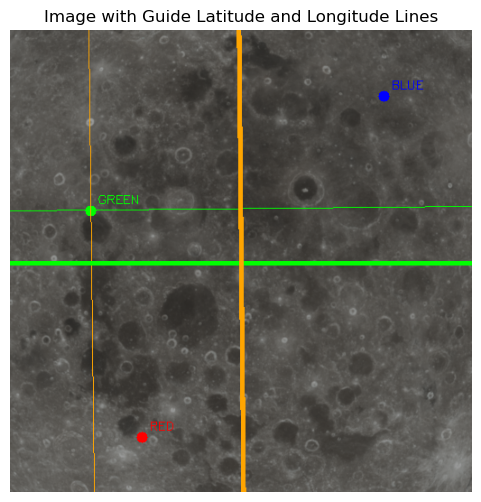

In [17]:
img_annotated4 = img_annotated3.copy()

A_lat = best_scenario["A_lat"]
y1_guide_lat = center_y - int(A_lat * (0 - center_x))
y2_guide_lat = center_y + int(A_lat * (W - 1 - center_x))
cv2.line(img_annotated4, (0, y1_guide_lat), (W - 1, y2_guide_lat), (0, 255, 0), 3)

A_lon = best_scenario["A_lon"]

if np.isfinite(A_lon):
    A_guide_lon = A_lon
    B_guide_lon = center_y - A_guide_lon * center_x

    print(f"A_lon: {A_lon}")
    print(f"B_lon: {B_lon}")
    print(f"A_guide_lon: {A_guide_lon}")
    print(f"B_guide_lon: {B_guide_lon}")

    x1_guide_lon, x2_guide_lon = 0, W - 1
    y1_guide_lon = int((center_y) - A_guide_lon * (x1_guide_lon - center_x))
    y2_guide_lon = int((center_y) - A_guide_lon * (x2_guide_lon - center_x))
    cv2.line(img_annotated4, (x1_guide_lon, y1_guide_lon), (x2_guide_lon, y2_guide_lon), (255, 165, 0), 3) 
else:
    A_guide_lon = float('inf')
    B_guide_lon = None
    print("A_guide_lon: inf (vertical line)")
    cv2.line(img_annotated4, (center_x, 0), (center_x, H - 1), (255, 165, 0), 3)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated4)
plt.title("Image with Guide Latitude and Longitude Lines")
plt.axis('off')
plt.show()

Intersection Points with *guide_lon* from perpendicular lines:
  Intersection 1: (258, 450)
  Intersection 2: (254, 75)


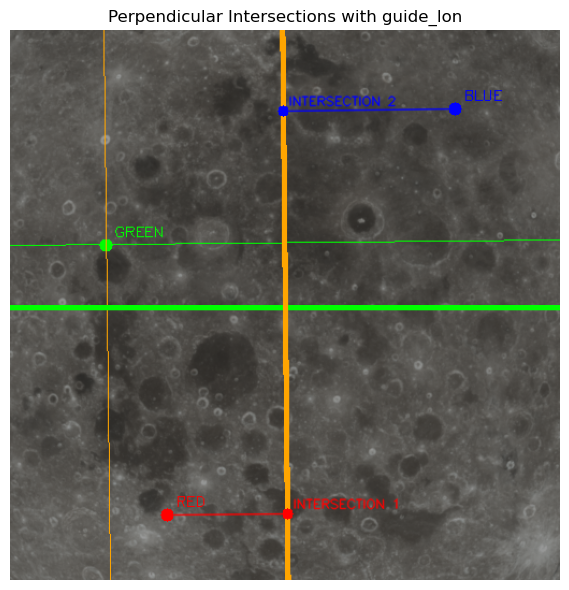

In [18]:
intersection_points = []
img_annotated5 = img_annotated4.copy() 

A1 = -A_lon
B1 = center_y + A_lon * center_x

for pt in remaining_points:
    x, y = pt["pixel"]

    if np.isfinite(A1):
        slope_perp = -1 / A1
        B_perp = y - slope_perp * x
        x_intersect = (B_perp - B1) / (A1 - slope_perp)
        y_intersect = A1 * x_intersect + B1
    else:
        x_intersect = center_x
        y_intersect = y 

    intersection_points.append((int(round(x_intersect)), int(round(y_intersect))))

print("Intersection Points with *guide_lon* from perpendicular lines:")
for i, pt in enumerate(intersection_points):
    print(f"  Intersection {i+1}: {pt}")


for i, (pt, inter_pt) in enumerate(zip(remaining_points, intersection_points)):
    x_start, y_start = pt["pixel"]
    x_end, y_end = inter_pt
    color = pt["color"] 

    cv2.line(img_annotated5, (x_start, y_start), (x_end, y_end),
             color=color, thickness=1, lineType=cv2.LINE_AA)

    cv2.circle(img_annotated5, (x_end, y_end), 5, color, -1)

    label = f"INTERSECTION {i+1}"
    cv2.putText(img_annotated5, label, (x_end + 5, y_end - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, lineType=cv2.LINE_AA)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated5)
plt.title("Perpendicular Intersections with guide_lon")
plt.axis('off')
plt.tight_layout()
plt.show()

In [19]:
intersection_data = []

for pt, inter_pt in zip(remaining_points, intersection_points):
    name = f"intersection_{pt['name'].lower()}"
    pixel = inter_pt
    lat = pt["lat"]
    entry = {
        "name": name,
        "pixel": pixel,
        "lat": lat
    }
    intersection_data.append(entry)

print("Intersection Points Dictionary:\n")
for entry in intersection_data:
    print(entry)


Intersection Points Dictionary:

{'name': 'intersection_red', 'pixel': (258, 450), 'lat': -58.668}
{'name': 'intersection_blue', 'pixel': (254, 75), 'lat': -34.682}


North Point: {'name': 'intersection_blue', 'pixel': (254, 75), 'lat': -34.682}
South Point: {'name': 'intersection_red', 'pixel': (258, 450), 'lat': -58.668}
North Vector (normalized): [-0.01066606 -0.99994312]


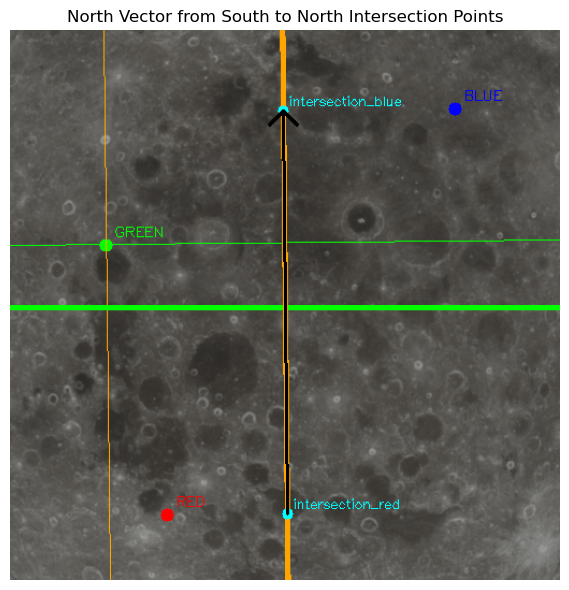

In [20]:
north_point = max(intersection_data, key=lambda d: d["lat"])
south_point = min(intersection_data, key=lambda d: d["lat"])

print("North Point:", north_point)
print("South Point:", south_point)

north_vector = np.array(north_point["pixel"]) - np.array(south_point["pixel"])
north_vector = north_vector / np.linalg.norm(north_vector) 

print("North Vector (normalized):", north_vector)

img_annotated6 = img_annotated4.copy()  

for entry in intersection_data:
    x, y = entry["pixel"]
    cv2.circle(img_annotated6, (x, y), 5, (0, 255, 255), -1)
    cv2.putText(img_annotated6, entry["name"], (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)

start = south_point["pixel"]
end = north_point["pixel"]
cv2.arrowedLine(img_annotated6, start, end, color=(0, 0, 0), thickness=2, tipLength=0.05)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated6)
plt.title("North Vector from South to North Intersection Points")
plt.axis('off')
plt.tight_layout()
plt.show()


257.2678517482997


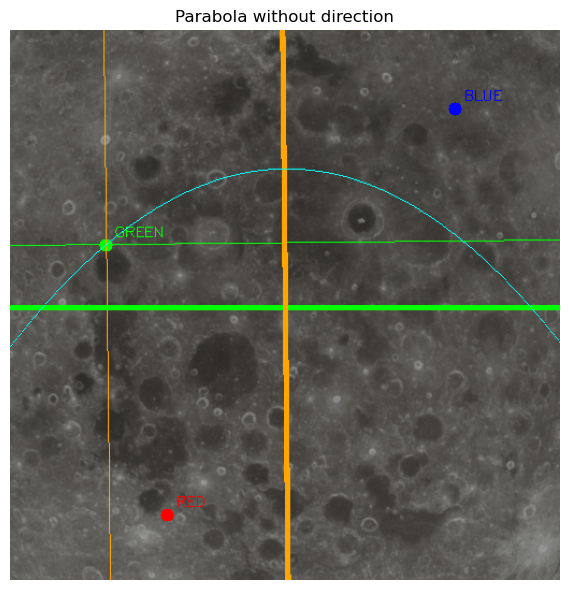

In [21]:
img_annotated7 = img_annotated4.copy()
a = 0.0025

A = a
B = A_guide_lon - 2 * a * x_main
C = a * x_main**2 + B_guide_lon - y_main

roots = np.roots([A, B, C])

for root in roots:
    if -W <= root < W:
        valid_root = root
    else:
        pass

r = valid_root
k = A_guide_lon * r + B_guide_lon
print(r)
        
x_vals = np.arange(0, W)
y_vals = a * (x_vals - r)**2 + A_guide_lon*r + B_guide_lon
y_vals = y_vals.astype(int)

for x, y in zip(x_vals, y_vals):
    if 0 <= y < H:
        img_annotated7[y, x] = (0, 255, 255)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated7)
plt.title("Parabola without direction")
plt.axis('off')
plt.tight_layout()
plt.show()

259.46586097582286


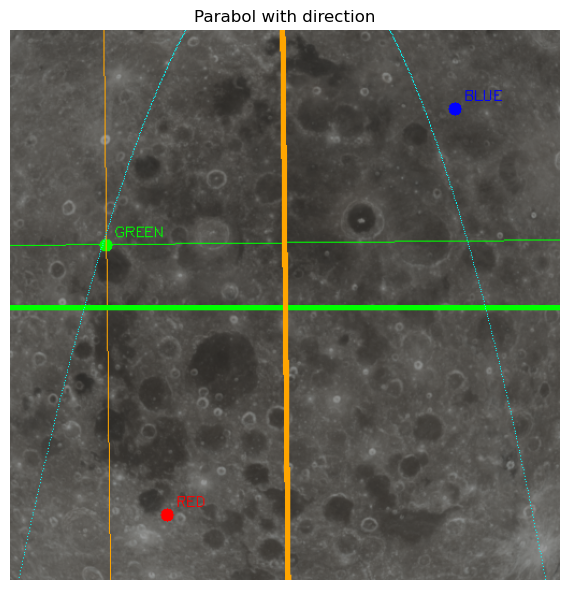

In [22]:
img_annotated8 = img_annotated4.copy()
a = 0.01

A = a
B = A_guide_lon - 2 * a * x_main
C = a * x_main**2 + B_guide_lon - y_main

roots = np.roots([A, B, C])

for root in roots:
    if -W <= root < W:
        valid_root = root
    else:
        pass

r = valid_root
k = A_guide_lon * r + B_guide_lon
print(r)
        
theta = np.arctan(A_guide_lon)+math.pi/2
t_vals = np.linspace(-300, 300, 1000)
for t in t_vals:
    x0 = t
    y0 = a * t**2

    x_rot = x0 * np.cos(theta) - y0 * np.sin(theta)
    y_rot = x0 * np.sin(theta) + y0 * np.cos(theta)

    x_final = int(round(x_rot + r))
    y_final = int(round(y_rot + k))

    if 0 <= x_final < W and 0 <= y_final < H:
        img_annotated8[y_final, x_final] = (0, 255, 255)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated8)
plt.title("Parabol with direction")
plt.axis('off')
plt.tight_layout()
plt.show()

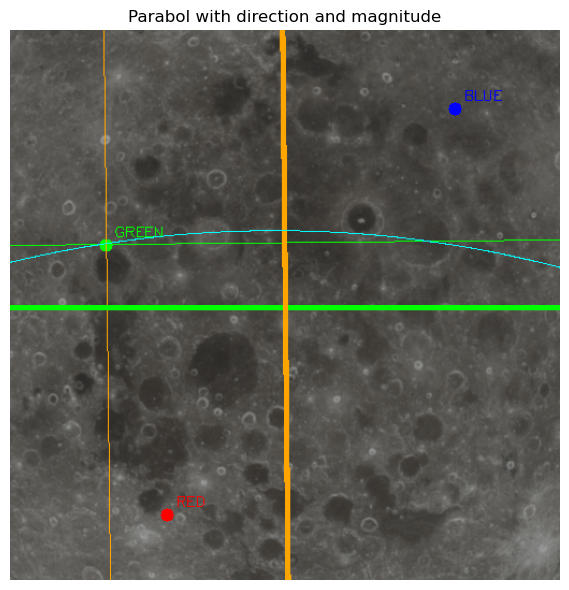

In [23]:
img_annotated9 = img_annotated4.copy()

a_determinor = main_point["lat"]
if a_determinor >= 0:
    col1 = np.arange(81)
    col2 = np.linspace(0, -0.001, 81)
    am = np.column_stack((col1, col2))
    a = am[int(a_determinor),1]
else:
    col1 = np.arange(81)
    col2 = np.linspace(0, 0.001, 81)
    am = np.column_stack((col1, col2))
    a = am[int(a_determinor),1]

A = a
B = A_guide_lon - 2 * a * x_main
C = a * x_main**2 + B_guide_lon - y_main

roots = np.roots([A, B, C])

for root in roots:
    if -W <= root < W:
        valid_root = root
    else:
        pass

r = valid_root
k = A_guide_lon * r + B_guide_lon
        
theta = np.arctan(A_guide_lon)+math.pi/2
t_vals = np.linspace(-300, 300, 1000)
for t in t_vals:
    x0 = t
    y0 = a * t**2

    x_rot = x0 * np.cos(theta) - y0 * np.sin(theta)
    y_rot = x0 * np.sin(theta) + y0 * np.cos(theta)

    x_final = int(round(x_rot + r))
    y_final = int(round(y_rot + k))

    if 0 <= x_final < W and 0 <= y_final < H:
        img_annotated9[y_final, x_final] = (0, 255, 255)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated9)
plt.title("Parabol with direction and magnitude")
plt.axis('off')
plt.tight_layout()
plt.show()


Enlem Parabol Parametre Sözlüğü:
GREEN → r: 256.70, k: 186.29, a: 0.000487
RED → r: 254.11, k: 445.30, a: 0.000488
BLUE → r: 257.95, k: 61.13, a: 0.000487


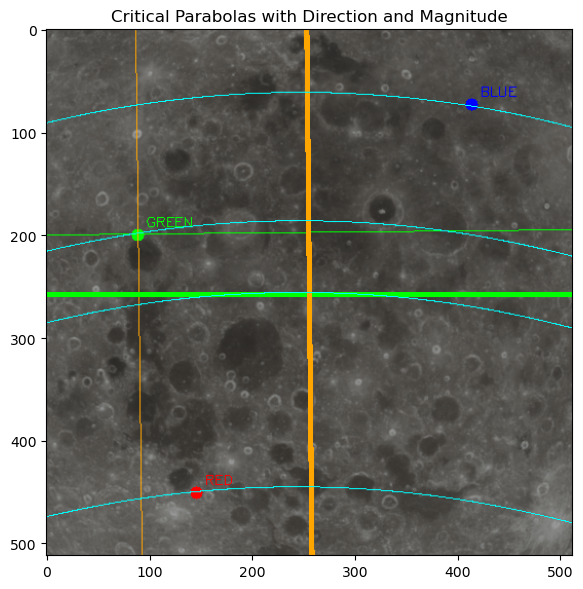

In [24]:
img_annotated10 = img_annotated4.copy()

a_determinor = main_point["lat"]
col1 = np.arange(81)
col2 = np.linspace(0, -0.001, 81) if a_determinor >= 0 else np.linspace(0, 0.001, 81)
am = np.column_stack((col1, col2))
a = am[int(a_determinor), 1]

points = [main_point, pt1, pt2]
parabola_color = (0, 255, 255)  # Tüm parabol çizgileri için aynı renk

vertex_dict = {} 
A_arr = np.full(3, a)
B_arr = np.zeros(3)
C_arr = np.zeros(3)
roots = np.empty((3, 2), dtype=complex)
valid_roots = np.full(3, np.nan)

for i, pt in enumerate(points):
    x = pt["pixel"][0]
    y = pt["pixel"][1]
    B_arr[i] = A_guide_lon - 2 * a * x
    C_arr[i] = a * x**2 + B_guide_lon - y
    roots[i] = np.roots([A_arr[i], B_arr[i], C_arr[i]])

    for root in roots[i]:
        if np.isreal(root):
            real_root = np.real(root)
            if -W <= real_root < W:
                valid_roots[i] = real_root
                break

for i, pt in enumerate(points):
    r = valid_roots[i]
    if np.isnan(r):
        continue 
    k = A_guide_lon * r + B_guide_lon
    vertex_dict[pt["name"]] = {"r": r, "k": k}
    theta = np.arctan(A_guide_lon) + math.pi / 2

    t_vals = np.linspace(-300, 300, 1000)
    for t in t_vals:
        x0 = t
        y0 = a * t**2

        x_rot = x0 * np.cos(theta) - y0 * np.sin(theta)
        y_rot = x0 * np.sin(theta) + y0 * np.cos(theta)

        x_final = int(round(x_rot + r))
        y_final = int(round(y_rot + k))

        if 0 <= x_final < W and 0 <= y_final < H:
            img_annotated10[y_final, x_final] = parabola_color

r_center = W // 2
k_center = H // 2

t_vals = np.linspace(-300, 300, 1000)
for t in t_vals:
    x0 = t
    y0 = a * t**2

    x_rot = x0 * np.cos(theta) - y0 * np.sin(theta)
    y_rot = x0 * np.sin(theta) + y0 * np.cos(theta)

    x_final = int(round(x_rot + r_center))
    y_final = int(round(y_rot + k_center))

    if 0 <= x_final < W and 0 <= y_final < H:
        img_annotated10[y_final, x_final] = parabola_color 


latitude_parabola_params = {}

for pt in points:
    px, py = pt["pixel"]
    r = vertex_dict[pt["name"]]["r"]
    k = vertex_dict[pt["name"]]["k"]

    dx = px - r
    dy = py - k

    if dx == 0:
        print(f"{pt['name']} noktasının x koordinatı tepe noktasıyla aynı, bu yüzden a tanımsız.")
        continue

    a = dy / (dx ** 2)

    latitude_parabola_params[pt["name"]] = {
        "r": r,
        "k": k,
        "a": a,
    }

print("\nEnlem Parabol Parametre Sözlüğü:")
for name, info in latitude_parabola_params.items():
    print(f'{name.upper()} → r: {info["r"]:.2f}, k: {info["k"]:.2f}, a: {info["a"]:.6f}')

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated10)
plt.title("Critical Parabolas with Direction and Magnitude")
plt.axis('on')
plt.tight_layout()
plt.show()

In [25]:
for name, coords in vertex_dict.items():
    print(f'Point: "{name.upper()}" r: {coords["r"]} k: {coords["k"]}')

# r ve k değerleri
r1 = vertex_dict[main_point["name"]]["r"]
k1 = vertex_dict[main_point["name"]]["k"]
r2 = vertex_dict[pt1["name"]]["r"]
k2 = vertex_dict[pt1["name"]]["k"]
r3 = vertex_dict[pt2["name"]]["r"]
k3 = vertex_dict[pt2["name"]]["k"]

# Piksel mesafeleri
distance1 = np.sqrt((r2 - r1)**2 + (k2 - k1)**2)
distance2 = np.sqrt((r3 - r1)**2 + (k3 - k1)**2)

print(f'\nTepe Noktası Piksel Uzaklıkları:')
print(f'{main_point["name"].upper()} ↔ {pt1["name"].upper()} : {distance1:.2f} piksel')
print(f'{main_point["name"].upper()} ↔ {pt2["name"].upper()} : {distance2:.2f} piksel')

# Gerçek enlem farkları
lat_main = main_point["lat"]
lat1 = pt1["lat"]
lat2 = pt2["lat"]

lat_diff1 = abs(lat_main - lat1)
lat_diff2 = abs(lat_main - lat2)

print(f'\nGerçek Enlem Farkları:')
print(f'{main_point["name"].upper()} ↔ {pt1["name"].upper()} : {lat_diff1:.3f}°')
print(f'{main_point["name"].upper()} ↔ {pt2["name"].upper()} : {lat_diff2:.3f}°')

center_dist_main = np.sqrt((r1 - r_center)**2 + (k1 - k_center)**2)
center_dist_pt1 = np.sqrt((r2 - r_center)**2 + (k2 - k_center)**2)
center_dist_pt2 = np.sqrt((r3 - r_center)**2 + (k3 - k_center)**2)

print(f'\nTepe Noktaları ile Merkez Nokta Arasındaki Piksel Uzaklıkları:')
print(f'{main_point["name"].upper()} ↔ CENTER : {center_dist_main:.2f} piksel')
print(f'{pt1["name"].upper()} ↔ CENTER : {center_dist_pt1:.2f} piksel')
print(f'{pt2["name"].upper()} ↔ CENTER : {center_dist_pt2:.2f} piksel')

# Piksel mesafeyi enlem farkına bölerek 1 derece başına düşen piksel mesafesi
pixels_per_degree_1 = distance1 / lat_diff1 if lat_diff1 != 0 else np.nan
pixels_per_degree_2 = distance2 / lat_diff2 if lat_diff2 != 0 else np.nan
average_pixels_per_degree = (pixels_per_degree_1 + pixels_per_degree_2) / 2

print(f'\n1° Enlem Farkına Karşılık Gelen Piksel Mesafesi:')
print(f'{main_point["name"].upper()} ↔ {pt1["name"].upper()} : {pixels_per_degree_1} px/°')
print(f'{main_point["name"].upper()} ↔ {pt2["name"].upper()} : {pixels_per_degree_2} px/°')

# Main point ile merkez arasındaki piksel uzaklığını dereceye çevirme
estimated_lat_diff_main_center = center_dist_main / average_pixels_per_degree if average_pixels_per_degree != 0 else np.nan

print(f'\nMAIN_POINT ↔ CENTER : Tahmini Enlem Farkı = {estimated_lat_diff_main_center:.3f}°')

Point: "GREEN" r: 256.6970962910091 k: 186.29037089909252
Point: "RED" r: 254.10697470014676 k: 445.30252998532524
Point: "BLUE" r: 257.9487160157615 k: 61.12839842385074

Tepe Noktası Piksel Uzaklıkları:
GREEN ↔ RED : 259.03 piksel
GREEN ↔ BLUE : 125.17 piksel

Gerçek Enlem Farkları:
GREEN ↔ RED : 15.934°
GREEN ↔ BLUE : 8.052°

Tepe Noktaları ile Merkez Nokta Arasındaki Piksel Uzaklıkları:
GREEN ↔ CENTER : 69.71 piksel
RED ↔ CENTER : 189.31 piksel
BLUE ↔ CENTER : 194.88 piksel

1° Enlem Farkına Karşılık Gelen Piksel Mesafesi:
GREEN ↔ RED : 16.256125854803443 px/°
GREEN ↔ BLUE : 15.544986390638464 px/°

MAIN_POINT ↔ CENTER : Tahmini Enlem Farkı = 4.384°


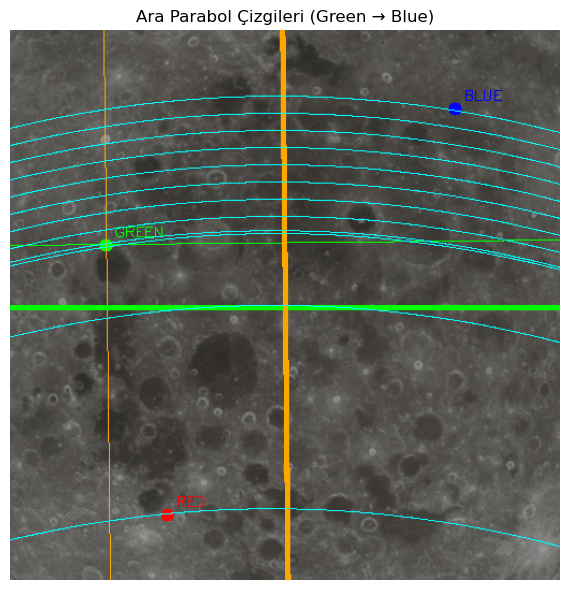

In [26]:
img_annotated11 = img_annotated10.copy()

r_green = valid_roots[0]
k_green = A_guide_lon * r_green + B_guide_lon
peak_green = np.array([r_green, k_green])
r_blue = valid_roots[2]
k_blue = A_guide_lon * r_blue + B_guide_lon
peak_blue = np.array([r_blue, k_blue])
peak_distance = np.linalg.norm(peak_blue - peak_green)

lat_green = main_point["lat"]
lat_blue = pt2["lat"]
lat_diff = abs(lat_green - lat_blue)

delta_raw = peak_distance/lat_diff
delta = int(round(delta_raw))

for offset in range(1, round(lat_diff) + 1):
    shift = offset * delta * -north_vector

    for t in t_vals:
        x0 = t
        y0 = a * t**2

        x_rot = x0 * np.cos(theta) - y0 * np.sin(theta)
        y_rot = x0 * np.sin(theta) + y0 * np.cos(theta)

        x_shifted = x_rot + shift[0]
        y_shifted = y_rot + shift[1]

        x_final = int(round(x_shifted + r))
        y_final = int(round(y_shifted + k))

        if 0 <= x_final < W and 0 <= y_final < H:
            img_annotated11[y_final, x_final] = parabola_color


plt.figure(figsize=(6, 6))
plt.imshow(img_annotated11)
plt.title("Ara Parabol Çizgileri (Green → Blue)")
plt.axis('off')
plt.tight_layout()
plt.show()



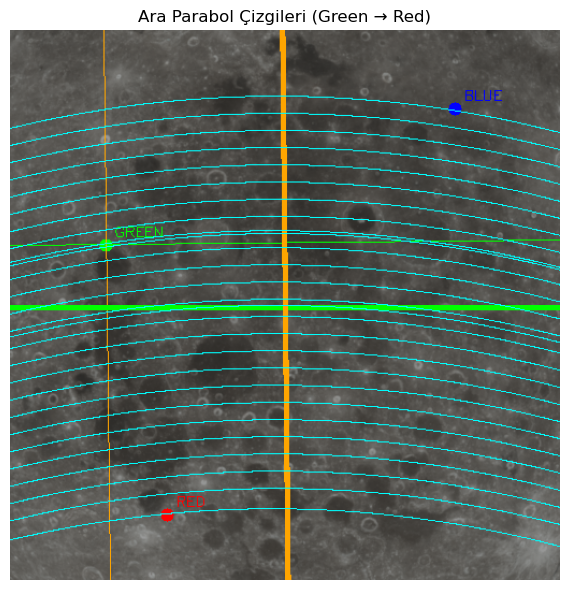

In [27]:
img_annotated12 = img_annotated11.copy()

# Tepe noktalarını al
r_green = valid_roots[0]
k_green = A_guide_lon * r_green + B_guide_lon
peak_green = np.array([r_green, k_green])

r_red = valid_roots[1]
k_red = A_guide_lon * r_red + B_guide_lon
peak_red = np.array([r_red, k_red])

# Piksel mesafesi ve latitude farkı
peak_distance_gr = np.linalg.norm(peak_red - peak_green)
lat_green = main_point["lat"]
lat_red = pt1["lat"]
lat_diff_gr = abs(lat_green - lat_red)

# Delta ve yön vektörü
delta_raw_gr = peak_distance_gr / lat_diff_gr
delta_gr = int(round(delta_raw_gr))
parabola_direction_gr = (peak_red - peak_green) / lat_diff_gr

# Ara parabol çizimi
for offset in range(1, round(lat_diff_gr)):
    shift = offset * delta_gr * -north_vector

    for t in t_vals:
        x0 = t
        y0 = a * t**2

        x_rot = x0 * np.cos(theta) - y0 * np.sin(theta)
        y_rot = x0 * np.sin(theta) + y0 * np.cos(theta)

        x_shifted = x_rot + shift[0]
        y_shifted = y_rot + shift[1]

        x_final = int(round(x_shifted + r_green))
        y_final = int(round(y_shifted + k_green))

        if 0 <= x_final < W and 0 <= y_final < H:
            img_annotated12[y_final, x_final] = parabola_color

# Görseli göster
plt.figure(figsize=(6, 6))
plt.imshow(img_annotated12)
plt.title("Ara Parabol Çizgileri (Green → Red)")
plt.axis('off')
plt.tight_layout()
plt.show()


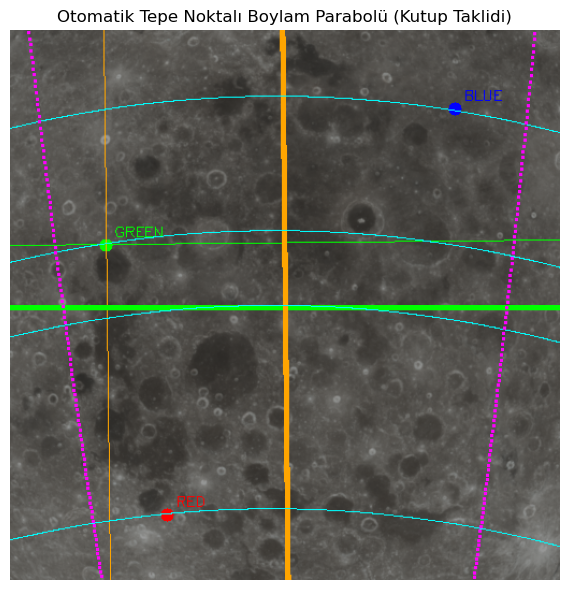

In [28]:
img_annotated13 = img_annotated10.copy()

a_lon = 0.02 #0.01
shift_coef = 20

#Gelecekteki bana a değeri için en geniş (kurtupsal kanzi) aralık tavsiyesi: 0.0005 - 1
#Gelecekteki bana shitf_coef değeri için en geniş (kurtupsal kanzi) aralık tavsiyesi: 6 - 90

# Tepe noktası referansı olarak görüntü merkezini al
center_point = np.array([W / 2, H / 2])

# Main noktanın enlem büyüklüğüne göre shift mesafesini hesapla
lat_shift_factor = abs(main_point["lat"])
shift_magnitude = lat_shift_factor * shift_coef  # bu katsayıyı duruma göre ayarlayabilirsin

# Yön belirle: pozitif enlem → north_vector yönünde uzaklaş, negatifse ters yönde
direction = north_vector if main_point["lat"] >= 0 else -north_vector

# Vektörü normalize et ve shift mesafesi kadar ölçekle
shift_vector = direction / np.linalg.norm(direction) * shift_magnitude

# Yeni tepe noktası koordinatları
peak_point = center_point + shift_vector

# r ve k: tepe noktası
r = int(round(peak_point[0]))
k = int(round(peak_point[1]))

angle = np.arctan2(north_vector[1], north_vector[0])
theta = angle - np.pi/2 

# Parabol çizimi
t_vals = np.linspace(-300, 300, 1000)
for t in t_vals:
    x0 = t
    y0 = a_lon * t**2

    x_rot = x0 * np.cos(theta) - y0 * np.sin(theta)
    y_rot = x0 * np.sin(theta) + y0 * np.cos(theta)

    x_final = int(round(x_rot + r))
    y_final = int(round(y_rot + k))

    if 0 <= x_final < W and 0 <= y_final < H:
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if 0 <= x_final + dx < W and 0 <= y_final + dy < H:
                    img_annotated13[y_final + dy, x_final + dx] = (255, 0, 255)

# Plotla
plt.figure(figsize=(6, 6))
plt.imshow(img_annotated13)
plt.title("Otomatik Tepe Noktalı Boylam Parabolü (Kutup Taklidi)")
plt.axis('off')
plt.tight_layout()
plt.show()

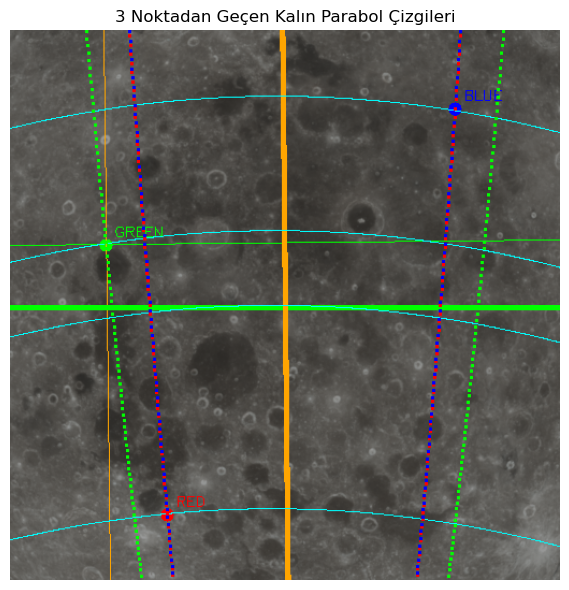

In [29]:
img_annotated14 = img_annotated10.copy()

a_values = {}
points = [main_point, pt1, pt2]  # 3 nokta

for pt in points:
    px, py = pt["pixel"]
    color = pt["color"]  # Noktanın kendi rengi

    # Tepe noktası sabit: (r, k)
    dx = px - r
    dy = py - k

    if dx == 0:
        print(f"{pt['name']} noktasının x koordinatı tepe noktasıyla aynı, bu yüzden a tanımsız.")
        continue

    a = dy / (dx ** 2)
    a_values[pt["name"]] = a

    t_vals = np.linspace(-300, 300, 1000)

    for t in t_vals:
        x0 = t
        y0 = a * t**2

        x_final = int(round(x0 + r))
        y_final = int(round(y0 + k))

        if 0 <= x_final < W and 0 <= y_final < H:
            # Kalın çizim için 3x3 bölgeyi boya
            for dx_thick in [-1, 0, 1]:
                for dy_thick in [-1, 0, 1]:
                    xx = x_final + dx_thick
                    yy = y_final + dy_thick
                    if 0 <= xx < W and 0 <= yy < H:
                        img_annotated14[yy, xx] = color
                        
plt.figure(figsize=(6, 6))
plt.imshow(img_annotated14)
plt.title("3 Noktadan Geçen Kalın Parabol Çizgileri")
plt.axis('off')
plt.tight_layout()
plt.show()



Boylam Parabol Parametre Sözlüğü:
GREEN → r: 265.00, k: 1111.00, a: -0.029410
RED → r: 265.00, k: 1111.00, a: -0.046607
BLUE → r: 265.00, k: 1111.00, a: -0.046755


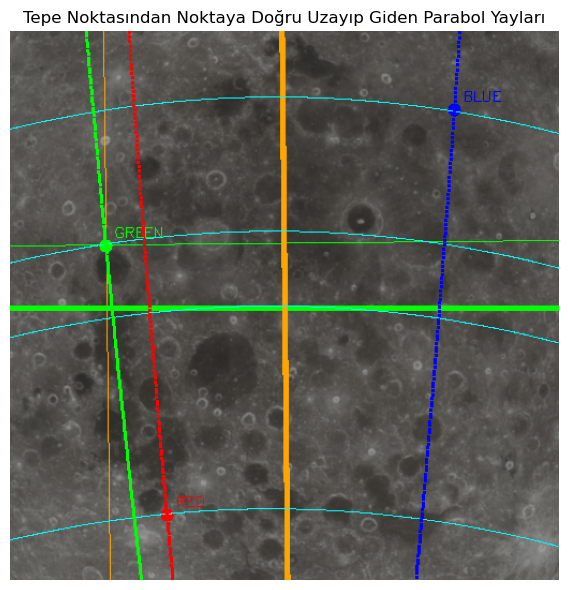

In [30]:
img_annotated15 = img_annotated10.copy()

a_values = {}
points = [main_point, pt1, pt2]  # 3 nokta

for pt in points:
    px, py = pt["pixel"]
    color = pt["color"]  # Noktanın kendi rengi

    # Tepe noktası sabit: (r, k)
    dx = px - r
    dy = py - k

    if dx == 0:
        print(f"{pt['name']} noktasının x koordinatı tepe noktasıyla aynı, bu yüzden a tanımsız.")
        continue

    a = dy / (dx ** 2)
    a_values[pt["name"]] = a

    # Parabol sadece noktaya doğru olan yönde, ileriye doğru uzasın
    t_max = 300  # Uzunluk kontrolü (dilersen artırıp azaltabilirsin)
    t_vals = np.linspace(0, t_max, 1000) if dx > 0 else np.linspace(0, -t_max, 1000)

    for t in t_vals:
        x0 = t
        y0 = a * t**2

        x_final = int(round(x0 + r))
        y_final = int(round(y0 + k))

        if 0 <= x_final < W and 0 <= y_final < H:
            for dx_thick in [-1, 0, 1]:
                for dy_thick in [-1, 0, 1]:
                    xx = x_final + dx_thick
                    yy = y_final + dy_thick
                    if 0 <= xx < W and 0 <= yy < H:
                        img_annotated15[yy, xx] = color


longitude_parabola_params = {}

for pt in points:
    px, py = pt["pixel"]

    # Tepe noktası sabit: (r, k)
    dx = px - r
    dy = py - k

    if dx == 0:
        print(f"{pt['name']} noktasının x koordinatı tepe noktasıyla aynı, bu yüzden a tanımsız.")
        continue

    a = dy / (dx ** 2)

    longitude_parabola_params[pt["name"]] = {
        "r": r,
        "k": k,
        "a": a,
    }

print("\nBoylam Parabol Parametre Sözlüğü:")
for name, info in longitude_parabola_params.items():
    r_str = f"{info['r']:.2f}"
    k_str = f"{info['k']:.2f}"
    a_str = f"{info['a']:.6f}"
    print(f'{name.upper()} → r: {r_str}, k: {k_str}, a: {a_str}')


plt.figure(figsize=(6, 6))
plt.imshow(img_annotated15)
plt.title("Tepe Noktasından Noktaya Doğru Uzayıp Giden Parabol Yayları")
plt.axis('off')
plt.tight_layout()
plt.show()


In [31]:
# Guide çizgisinden bir referans nokta (örneğin ekranın ortası)
x0, y0 = int(W / 2), int(A_guide_lon * (W / 2) + B_guide_lon)

# Guide çizgisinin yön vektörü: 1 birim sağa gidince ne kadar yukarı çıkıyor?
dx = 1
dy = A_guide_lon * dx

left_side = []
right_side = []

# Her noktanın guide çizgisine göre hangi tarafta kaldığını belirle
for pt in [main_point, pt1, pt2]:
    x, y = pt["pixel"]
    orientation = (x - x0) * dy - (y - y0) * dx  # Vektörel çarpım benzeri ifade

    if orientation > 0:
        left_side.append(pt)
    elif orientation < 0:
        right_side.append(pt)
    else:
        print(f"{pt['name']} guide_lon çizgisi üzerinde.")

# En az iki noktanın bulunduğu tarafı seç
if len(left_side) >= 2:
    selected_pair = left_side[:2]
    side_name = "Sol"
elif len(right_side) >= 2:
    selected_pair = right_side[:2]
    side_name = "Sağ"
else:
    selected_pair = []
    side_name = "Yetersiz ikili"

# Merkez noktayı tanımla (daha önceden belirlenmişti zaten)
center_point = np.array([W // 2, H // 2])

# İkili varsa işlem yap
if len(selected_pair) == 2:
    distances = []
    for pt in selected_pair:
        pixel = np.array(pt["pixel"])
        dist = np.linalg.norm(pixel - center_point)
        distances.append(dist)

    # En yakın olan kritik nokta, diğeri yardımcı
    if distances[0] <= distances[1]:
        critical_point = selected_pair[0]
        assistant_point = selected_pair[1]
    else:
        critical_point = selected_pair[1]
        assistant_point = selected_pair[0]

    # Sözlük oluştur
    critical_pair_dict = {
        "critical_point": {
            "name": critical_point["name"],
            "lat": critical_point["lat"],
            "lon": critical_point["lon"],
            "pixel": critical_point["pixel"],
            "a": a_values[critical_point["name"]]
        },
        "assistant_point": {
            "name": assistant_point["name"],
            "lat": assistant_point["lat"],
            "lon": assistant_point["lon"],
            "pixel": assistant_point["pixel"],
            "a": a_values[assistant_point["name"]]
        }
    }

    print("\nKritik Nokta Sözlüğü:")
    for key, info in critical_pair_dict.items():
        print(f'{key.upper()} → {info["name"].upper()} | lat: {info["lat"]:.3f} | lon: {info["lon"]:.3f} | '
              f'pixel: {info["pixel"]} | a: {info["a"]:.6f}')

else:
    print("\nİkili seçilemedi, kritik nokta oluşturulamadı.")


Kritik Nokta Sözlüğü:
CRITICAL_POINT → GREEN | lat: -42.734 | lon: 75.612 | pixel: (89, 200) | a: -0.029410
ASSISTANT_POINT → RED | lat: -58.668 | lon: 76.997 | pixel: (146, 451) | a: -0.046607



Kesişim Noktası Sözlüğü:
GUIDE_LON_INTERSECTION → x: 257, y: 186
ASSISTANT #1 → x: 124, y: 195


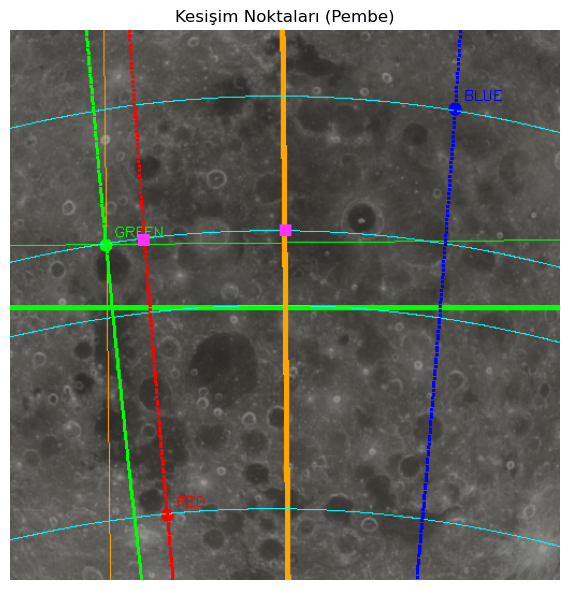

In [41]:
img_annotated16 = img_annotated15.copy()

def filter_close_points(points, tolerance=2):
    unique_points = []
    for pt in points:
        x1, y1 = pt
        too_close = False
        for up in unique_points:
            x2, y2 = up
            if np.hypot(x2 - x1, y2 - y1) < tolerance:
                too_close = True
                break
        if not too_close:
            unique_points.append(pt)
    return unique_points

def find_parabola_intersections(r1, k1, a1, r2, k2, a2, t_range=300, resolution=1000):
    t_vals = np.linspace(-t_range, t_range, resolution)

    x1 = r1 + t_vals
    y1 = k1 + a1 * t_vals**2

    x2 = r2 + t_vals
    y2 = k2 + a2 * t_vals**2

    intersection_points = []
    
    for i in range(resolution):
        xi1, yi1 = x1[i], y1[i]

        distances = np.sqrt((xi1 - x2)**2 + (yi1 - y2)**2)
        if np.any(distances < 1.0):  # Tolerans: 1 piksel
            intersection_points.append((int(round(xi1)), int(round(yi1))))

    intersection_points = filter_close_points(intersection_points, tolerance=2)
    return intersection_points

# 1. Nokta bilgilerini al
cp_name = critical_pair_dict["critical_point"]["name"]
ap_name = critical_pair_dict["assistant_point"]["name"]

# 2. Paraboller arası kesişim
cp_lat = latitude_parabola_params[cp_name]     # critical_point’in enlem parabolü
ap_lon = longitude_parabola_params[ap_name]    # assistant_point’in boylam parabolü

assistant_intersection = find_parabola_intersections(
    r1=cp_lat["r"], k1=cp_lat["k"], a1=cp_lat["a"],
    r2=ap_lon["r"], k2=ap_lon["k"], a2=ap_lon["a"],
    t_range=300, resolution=1000
)

# Pembe renk
pink = (255, 50, 255)

# Yardımcı fonksiyon: Nokta çizdir
def draw_dot(img, x, y, color=pink, radius=5):
    for dx in range(-radius, radius+1):
        for dy in range(-radius, radius+1):
            xx = x + dx
            yy = y + dy
            if 0 <= xx < W and 0 <= yy < H:
                img[yy, xx] = color

for pt in assistant_intersection:
    x, y = pt
    draw_dot(img_annotated16, x, y, pink, radius=5)

guide_lon_intersection = latitude_parabola_params[critical_point["name"]]["r"], latitude_parabola_params[critical_point["name"]]["k"]
draw_dot(img_annotated16, int(guide_lon_intersection[0]), int(guide_lon_intersection[1]), color=(255, 50, 255), radius=5)


intersection_points_dict = {
    "guide_lon_intersection": {
        "x": int(round(guide_lon_intersection[0])),
        "y": int(round(guide_lon_intersection[1]))
    },
    "assistant_intersections": []
}

for pt in assistant_intersection:
    x, y = pt
    intersection_points_dict["assistant_intersections"].append({
        "x": x,
        "y": y
    })

# Sözlük çıktısı:
print("\nKesişim Noktası Sözlüğü:")
for key, value in intersection_points_dict.items():
    if key == "assistant_intersections":
        for i, item in enumerate(value):
            print(f"ASSISTANT #{i+1} → x: {item['x']}, y: {item['y']}")
    else:
        print(f"{key.upper()} → x: {value['x']}, y: {value['y']}")

# Görselleştir
plt.figure(figsize=(6, 6))
plt.imshow(img_annotated16)
plt.title("Kesişim Noktaları (Pembe)")
plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
# Yay uzunluğu hesabı için fonksiyon
def arc_length_on_parabola(t1, t2, a):
    integrand = lambda t: np.sqrt(1 + (2 * a * t)**2)
    length, _ = quad(integrand, t1, t2)
    return length

# 1. Parabol parametreleri
r_cp = cp_lat["r"]
k_cp = cp_lat["k"]
a_cp = cp_lat["a"]

x_cp, y_cp = critical_pair_dict["critical_point"]["pixel"]
theta_cp = np.arctan(A_guide_lon) + np.pi / 2

# 2. Assistant noktalar için yay mesafesi
for item in intersection_points_dict["assistant_intersections"]:
    x, y = item["x"], item["y"]

    dx = x - x_cp
    dy = y - y_cp
    t_approx = (dx * np.cos(theta_cp) + dy * np.sin(theta_cp))
    arc = arc_length_on_parabola(0, t_approx, a_cp)
    item["arc_distance_to_cp"] = abs(arc)

# 3. Guide noktası için yay mesafesi
gx = intersection_points_dict["guide_lon_intersection"]["x"]
gy = intersection_points_dict["guide_lon_intersection"]["y"]

dx_g = gx - x_cp
dy_g = gy - y_cp
t_approx_g = (dx_g * np.cos(theta_cp) + dy_g * np.sin(theta_cp))
arc_g = arc_length_on_parabola(0, t_approx_g, a_cp)

intersection_points_dict["guide_lon_intersection"]["arc_distance_to_cp"] = arc_g

# 4. Yazdır
print("\nAssistant Noktalarının Critical Point'e Yay Mesafeleri:")
for i, item in enumerate(intersection_points_dict["assistant_intersections"]):
    print(f"ASSISTANT #{i+1} → Yay uzunluğu: {item['arc_distance_to_cp']:.2f} piksel")

print("\nGuide Noktasının Critical Point'e Yay Mesafesi:")
print(f"GUIDE → Yay uzunluğu: {intersection_points_dict['guide_lon_intersection']['arc_distance_to_cp']:.2f} piksel")



Assistant Noktalarının Critical Point'e Yay Mesafeleri:
ASSISTANT #1 → Yay uzunluğu: 34.96 piksel

Guide Noktasının Critical Point'e Yay Mesafesi:
GUIDE → Yay uzunluğu: 168.60 piksel


In [39]:
# 1. Yay uzunluklarını al
arc_guide = intersection_points_dict["guide_lon_intersection"]["arc_distance_to_cp"]
arc_assistant = intersection_points_dict["assistant_intersections"][0]["arc_distance_to_cp"]

# 2. Boylam farkı (değişmiyor)
lon_cp = critical_pair_dict["critical_point"]["lon"]
lon_assistant = critical_pair_dict["assistant_point"]["lon"]
delta_lon = abs(lon_assistant - lon_cp)

# 3. Yazdır
print("Yay uzunlukları:")
print(f"→ Critical vs Guide : Yay uzunluğu = {arc_guide:.2f} px")
print(f"→ Critical vs Assistant : Yay uzunluğu = {arc_assistant:.2f} px")

print("\nBoylam farkı:")
print(f"→ Critical vs Assistant : Δlon = {delta_lon:.4f}°")

# 4. Kritik vs Guide boylam farkının oranla tahmini
estimated_delta_lon_guide = (delta_lon / arc_assistant) * arc_guide

print("\nTahmini Boylam farkı (Kritik vs Guide) [Yay tabanlı hesap]:")
print(f"→ Δlon ≈ {estimated_delta_lon_guide:.4f}°")

Yay uzunlukları:
→ Critical vs Guide : Yay uzunluğu = 168.60 px
→ Critical vs Assistant : Yay uzunluğu = 34.96 px

Boylam farkı:
→ Critical vs Assistant : Δlon = 1.3850°

Tahmini Boylam farkı (Kritik vs Guide) [Yay tabanlı hesap]:
→ Δlon ≈ 6.6802°
